# <center>Project of Machine Learning</center>

<center>
Master in Data Science and Advanced Analytics <br>
NOVA Information Management School
</center>

** **
## <center>*TO GRANT OR NOT TO GRANT: DECIDING ON COMPENSATION BENEFITS*</center>

<center>
Group 17 <br>
Diogo Ruivo, 20240584  <br>
José Tiago, 20240582  <br>
Matilde Miguel, 20240549  <br>
Nuno Sousa, 20222125  <br>
Rafael Lopes, 20240588  <br>



    
</center>


** **

## Project Description     
This project addresses the task of automating decisions on compensation in insurance claims related to workplace injuries. Using historical data from the New York WCB, our objective is to predict the type of compensation a claim will be awarded, thereby optimizing the decision-making process and improving consistency in outcomes.   

This project aims to build a robust predictive model to classify injury claims in a multiclass classification scenario, explore and optimize model performance through preprocessing techniques and hyperparameter tuning and provide interpretative analysis to identify the most influential variables in the final decision.   

Prior studies show that machine learning techniques, such as random forests and XGBoost, have proven effective in automating decision-making processes in insurance. Our work builds on these approaches, exploring multiple variables related to demographics and injury types to create an interpretable and reliable decision-making model.


In [619]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

# Data manipulation and analysis
from sklearn.model_selection import train_test_split
import missingno as msno
from sklearn.impute import KNNImputer, SimpleImputer

# Feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer
import statistics

# Feature selection
from scipy.stats import chi2_contingency, spearmanr
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

# Scaling and encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder

# Modeling
from sklearn.linear_model import LogisticRegression, LassoCV, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier

# Model evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve, auc, precision_score, recall_score

# Resampling
from imblearn.over_sampling import SMOTE

# Model selection
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, cross_val_score, StratifiedKFold

# Pipeline
from sklearn.pipeline import make_pipeline

<hr>
<a class="anchor" id="importdataset">
    
# 2. Import Dataset
    
</a>

In [620]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
sample_submission = pd.read_csv('sample_submission.csv')

we had one of the missing columns of test, using as example the one in train

In [621]:
%store -r Agreement_Reached
test['Agreement Reached'] = Agreement_Reached

after adding the column we organize the test dataset to have the same column order as the train dataset

In [622]:
cols = test.columns.tolist()
cols[-2], cols[-1] = cols[-1], cols[-2]
test = test[cols]

<hr>
<a class="anchor" id="initialanalysis">
    
# 3. Initial Analysis
    
</a>



In [623]:
train.head(10)

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,...,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,...,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,...,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0
5,2019-12-26,67.0,N,2020-01-01,N,0.00,1952.0,2019-12-31,NaN,INDEMNITY INS. OF N AMERICA,...,31.0,"FALL, SLIP OR TRIP, NOC",10.0,CONTUSION,38.0,SHOULDER(S),11772,0.0,Not Work Related,5.0
6,2019-12-28,48.0,N,2020-01-01,N,0.00,1971.0,2019-12-31,NaN,LM INSURANCE CORP,...,19.0,"CUT, PUNCTURE, SCRAPE, NOC",40.0,LACERATION,36.0,FINGER(S),13029,0.0,Not Work Related,1.0
7,2019-12-30,33.0,N,2020-01-01,N,0.00,1986.0,2019-12-31,2020-03-04,STATE INSURANCE FUND,...,99.0,"OTHER - MISCELLANEOUS, NOC",71.0,"ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC",38.0,SHOULDER(S),10305,0.0,Not Work Related,6.0
8,2019-12-23,55.0,N,2020-01-01,N,0.00,1964.0,2020-01-01,NaN,"ROCHESTER, UNIVERSITY OF",...,99.0,"OTHER - MISCELLANEOUS, NOC",59.0,"ALL OTHER SPECIFIC INJURIES, NOC",60.0,LUNGS,14620,0.0,Not Work Related,6.0
9,2019-12-29,20.0,N,2020-01-01,N,225.00,NaN,2019-12-31,NaN,LM INSURANCE CORP,...,81.0,"STRUCK OR INJURED, NOC",59.0,"ALL OTHER SPECIFIC INJURIES, NOC",14.0,EYE(S),11231,0.0,Not Work Related,6.0


In [624]:
test.head(10)

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,Number of Dependents
0,2022-12-24,19,N,2023-01-02,N,NaN,2003.0,2023-01-02,NaN,INDEMNITY INSURANCE CO OF,...,NaN,31.0,"FALL, SLIP OR TRIP, NOC",10.0,CONTUSION,54.0,LOWER LEG,10466,0.0,1
1,2022-11-20,19,N,2023-01-02,N,NaN,2003.0,2023-01-02,NaN,A I U INSURANCE COMPANY,...,NaN,75.0,FALLING OR FLYING OBJECT,10.0,CONTUSION,10.0,MULTIPLE HEAD INJURY,11691,0.0,1
2,2022-12-26,59,N,2023-01-02,N,0.00,1963.0,2022-12-31,NaN,AMGUARD INSURANCE COMPANY,...,NaN,68.0,STATIONARY OBJECT,49.0,SPRAIN OR TEAR,62.0,BUTTOCKS,10604,0.0,0
3,2022-12-28,55,N,2023-01-02,N,0.00,0.0,2023-01-02,NaN,INDEMNITY INS. OF N AMERICA,...,NaN,25.0,FROM DIFFERENT LEVEL (ELEVATION),10.0,CONTUSION,53.0,KNEE,11411,0.0,6
4,2022-12-20,25,N,2023-01-02,N,0.00,1997.0,2022-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,...,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,40.0,LACERATION,37.0,THUMB,11212,0.0,5
5,2022-12-28,36,N,2023-01-02,N,0.00,1986.0,2023-01-02,NaN,NYC TRANSIT AUTHORITY,...,NaN,90.0,OTHER THAN PHYSICAL CAUSE OF INJURY,77.0,MENTAL STRESS,66.0,NO PHYSICAL INJURY,10941,0.0,4
6,2022-12-22,19,N,2023-01-02,N,688.20,2003.0,2022-12-30,NaN,"WAL-MART ASSOCIATES, INC.",...,NaN,56.0,LIFTING,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14131,0.0,6
7,2022-12-13,43,N,2023-01-02,N,0.00,0.0,2023-01-02,NaN,ERIE INSURANCE CO OF NY,...,NaN,27.0,FROM LIQUID OR GREASE SPILLS,49.0,SPRAIN OR TEAR,53.0,KNEE,13357,0.0,4
8,2022-12-28,40,N,2023-01-02,N,0.00,1982.0,2022-12-31,NaN,STARR INDEMNITY & LIABILITY CO,...,NaN,87.0,FOREIGN MATTER (BODY) IN EYE(S),25.0,FOREIGN BODY,14.0,EYE(S),11735,0.0,3
9,2022-11-01,48,N,2023-01-02,Y,1180.74,1974.0,2023-01-02,2023-01-09,STATE INSURANCE FUND,...,NaN,25.0,FROM DIFFERENT LEVEL (ELEVATION),49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14720,0.0,0


In [625]:
print("Train dimensions:", train.shape)
print("Test dimensions:", test.shape)

Train dimensions: (593471, 33)
Test dimensions: (387975, 31)


In [626]:
print("Train columns:", train.columns)
print("Test columns:", test.columns)

Train columns: Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'Claim Identifier', 'Claim Injury Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender',
       'IME-4 Count', 'Industry Code', 'Industry Code Description',
       'Medical Fee Region', 'OIICS Nature of Injury Description',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code',
       'Agreement Reached', 'WCB Decision', 'Number of Dependents'],
      dtype='object')
Test columns: Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',


In [627]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       593471 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  Claim Identifier          

In [628]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387975 entries, 0 to 387974
Data columns (total 31 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       385531 non-null  object 
 1   Age at Injury                       387975 non-null  int64  
 2   Alternative Dispute Resolution      387975 non-null  object 
 3   Assembly Date                       387975 non-null  object 
 4   Attorney/Representative             387975 non-null  object 
 5   Average Weekly Wage                 368771 non-null  float64
 6   Birth Year                          368505 non-null  float64
 7   C-2 Date                            378841 non-null  object 
 8   C-3 Date                            85216 non-null   object 
 9   Carrier Name                        387975 non-null  object 
 10  Carrier Type                        387975 non-null  object 
 11  Claim Identifier          

In [629]:
train.describe(include ='all')

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
count,570337,574026.000000,574026,593471,574026,5.453750e+05,544948.000000,559466,187245,574026,...,558386.000000,558386,558369.000000,558369,556944.000000,556944,545389,574026.000000,574026,574026.000000
unique,5539,NaN,3,1096,2,NaN,NaN,2475,1648,2046,...,NaN,74,NaN,56,NaN,54,10060,NaN,1,NaN
top,2020-03-01,NaN,N,2020-03-06,N,NaN,NaN,2021-05-11,2021-04-21,STATE INSURANCE FUND,...,NaN,LIFTING,NaN,STRAIN OR TEAR,NaN,LOWER BACK AREA,11236,NaN,Not Work Related,NaN
freq,1245,NaN,571412,1422,392291,NaN,NaN,1847,350,111144,...,NaN,46610,NaN,153373,NaN,51862,3302,NaN,574026,NaN
mean,NaN,42.114270,NaN,NaN,NaN,4.910883e+02,1886.767604,NaN,NaN,NaN,...,54.381143,NaN,41.013839,NaN,39.738146,NaN,NaN,0.046665,NaN,3.006559
std,NaN,14.256432,NaN,NaN,NaN,6.092918e+03,414.644423,NaN,NaN,NaN,...,25.874281,NaN,22.207521,NaN,22.365940,NaN,NaN,0.210921,NaN,2.000801
min,NaN,0.000000,NaN,NaN,NaN,0.000000e+00,0.000000,NaN,NaN,NaN,...,1.000000,NaN,1.000000,NaN,-9.000000,NaN,NaN,0.000000,NaN,0.000000
25%,NaN,31.000000,NaN,NaN,NaN,0.000000e+00,1965.000000,NaN,NaN,NaN,...,31.000000,NaN,16.000000,NaN,33.000000,NaN,NaN,0.000000,NaN,1.000000
50%,NaN,42.000000,NaN,NaN,NaN,0.000000e+00,1977.000000,NaN,NaN,NaN,...,56.000000,NaN,49.000000,NaN,38.000000,NaN,NaN,0.000000,NaN,3.000000
75%,NaN,54.000000,NaN,NaN,NaN,8.410000e+02,1989.000000,NaN,NaN,NaN,...,75.000000,NaN,52.000000,NaN,53.000000,NaN,NaN,0.000000,NaN,5.000000


In [630]:
test.describe(include = 'all')

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,Number of Dependents
count,385531,387975.000000,387975,387975,387975,3.687710e+05,368505.000000,378841,85216,387975,...,0.0,377627.000000,377627,377415.000000,377415,378426.000000,378426,368633,387975.000000,387975.000000
unique,3438,NaN,3,434,2,NaN,NaN,1048,626,1598,...,NaN,NaN,74,NaN,56,NaN,51,6276,NaN,NaN
top,2024-01-16,NaN,N,2023-09-21,N,NaN,NaN,2023-10-11,2023-10-04,STATE INSURANCE FUND,...,NaN,NaN,"FELLOW WORKER, PATIENT OR OTHER PERSON",NaN,STRAIN OR TEAR,NaN,MULTIPLE,11368,NaN,NaN
freq,1263,NaN,386314,1789,306476,NaN,NaN,1687,341,66189,...,NaN,NaN,33293,NaN,108326,NaN,67465,2068,NaN,NaN
mean,NaN,41.414944,NaN,NaN,NaN,1.833438e+02,1875.383466,NaN,NaN,NaN,...,NaN,53.335678,NaN,38.373674,NaN,31.516109,NaN,NaN,0.004472,3.000284
std,NaN,14.501056,NaN,NaN,NaN,3.542310e+03,444.659075,NaN,NaN,NaN,...,NaN,26.176833,NaN,20.966100,NaN,23.359950,NaN,NaN,0.066723,1.997982
min,NaN,0.000000,NaN,NaN,NaN,0.000000e+00,0.000000,NaN,NaN,NaN,...,NaN,1.000000,NaN,1.000000,NaN,-9.000000,NaN,NaN,0.000000,0.000000
25%,NaN,30.000000,NaN,NaN,NaN,0.000000e+00,1967.000000,NaN,NaN,NaN,...,NaN,29.000000,NaN,10.000000,NaN,15.000000,NaN,NaN,0.000000,1.000000
50%,NaN,40.000000,NaN,NaN,NaN,0.000000e+00,1980.000000,NaN,NaN,NaN,...,NaN,56.000000,NaN,43.000000,NaN,36.000000,NaN,NaN,0.000000,3.000000
75%,NaN,53.000000,NaN,NaN,NaN,0.000000e+00,1992.000000,NaN,NaN,NaN,...,NaN,74.000000,NaN,52.000000,NaN,51.000000,NaN,NaN,0.000000,5.000000


<hr>
<a class="anchor" id="furtheranalysis">
    
## 3.1 Further Analysis
    
</a>

In [631]:
print('youngest person:',train['Birth Year'].max())
print('oldest injured:',train['Age at Injury'].max())
print('most dependents:',train['Number of Dependents'].max())

youngest person: 2018.0
oldest injured: 117.0
most dependents: 6.0


In [632]:
for i in train.columns:
    print(i)
    print(train[i].unique())
    print(train[i].value_counts())
    print('\n')

Accident Date
['2019-12-30' '2019-08-30' '2019-12-06' ... '2000-05-24' '2007-05-01'
 '1980-05-17']
Accident Date
2020-03-01    1245
2020-12-18    1001
2022-02-07     977
2022-01-05     883
2021-02-18     851
              ... 
2017-05-17       1
2015-05-28       1
2002-08-18       1
2017-09-01       1
1980-05-17       1
Name: count, Length: 5539, dtype: int64


Age at Injury
[ 31.  46.  40.  nan  61.  67.  48.  33.  55.  20.  21.  51.  62.  35.
  54.  32.  34.  38.  30.  36.  39.  44.  56.  29.  60.  49.  50.  18.
  58.  24.  45.  53.  52.  47.  25.  23.  22.  64.  70.  41.  69.  57.
  27.  42.  77.  72.  19.  28.  63.  65.  59.  43.  26.  74.  66.  76.
  68.  37.   0.  16.  71.  82.  75.  17.  78.  73.  89.  85.  84.  81.
  87.  80.  11.  88.  79.  15.  83.  86.  90.   1.  10. 102.  94. 117.
  14. 113.  95.  92. 104.   5.   8. 115. 110.  91.  96.  99.  12.  13.
  93. 101.   7. 111.   9.  97. 112. 109. 100.  98. 114.]
Age at Injury
31.0     14041
30.0     14022
32.0     13994
29.0     

<hr>
<a class="anchor" id="graphicalrepresentaion">
    
### 3.1.1 Graphical Representaion
    
</a>

In [633]:
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train.select_dtypes(include=[object]).columns.tolist()

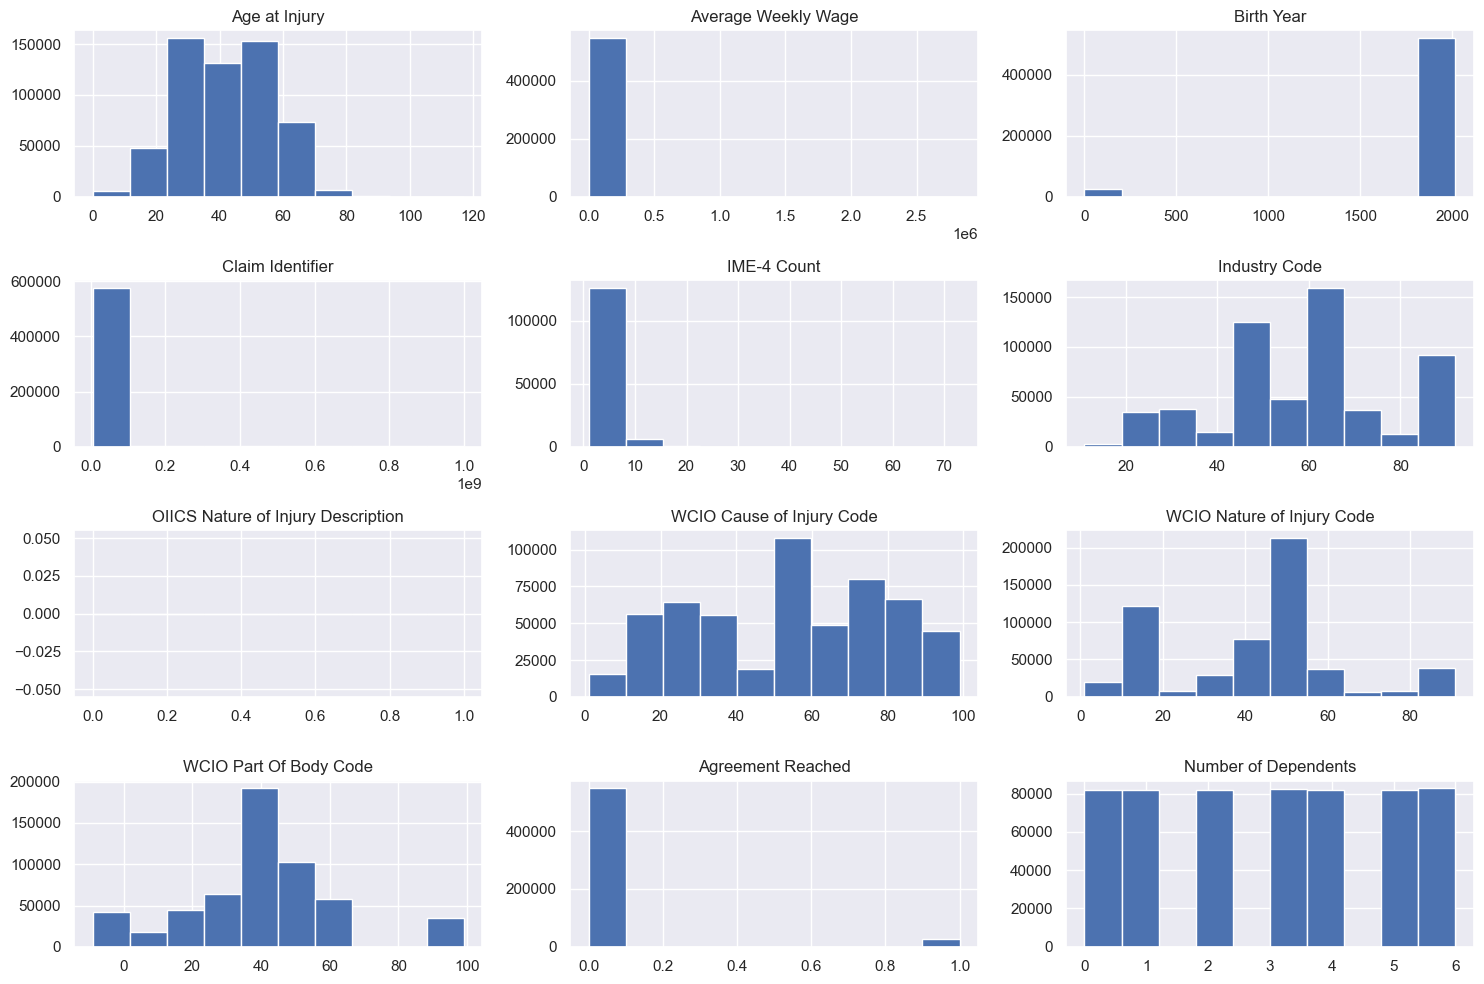

In [634]:
train[numerical_cols].hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

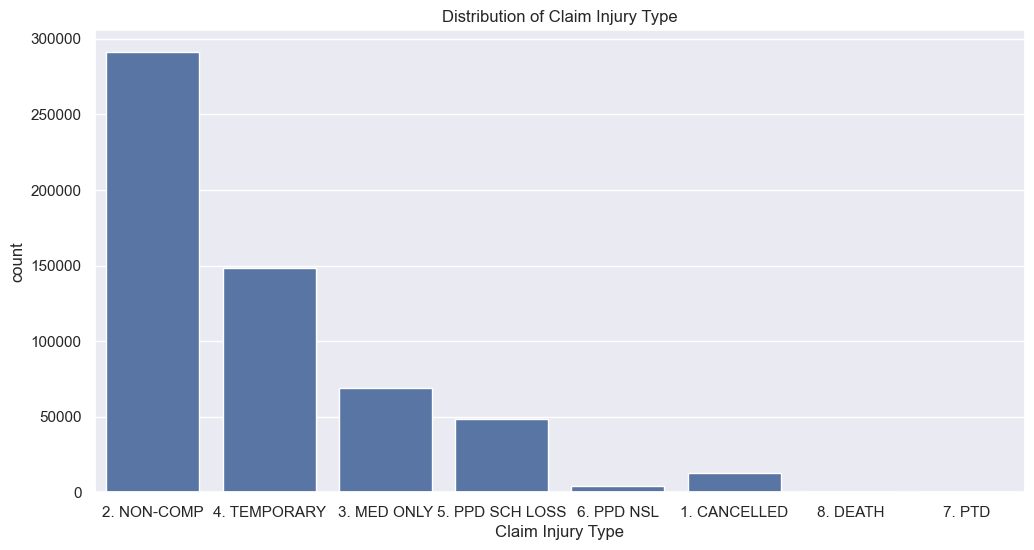

In [635]:
plt.figure(figsize=(12, 6))
sns.countplot( x= 'Claim Injury Type', data = train)
plt.title('Distribution of Claim Injury Type')
plt.show()

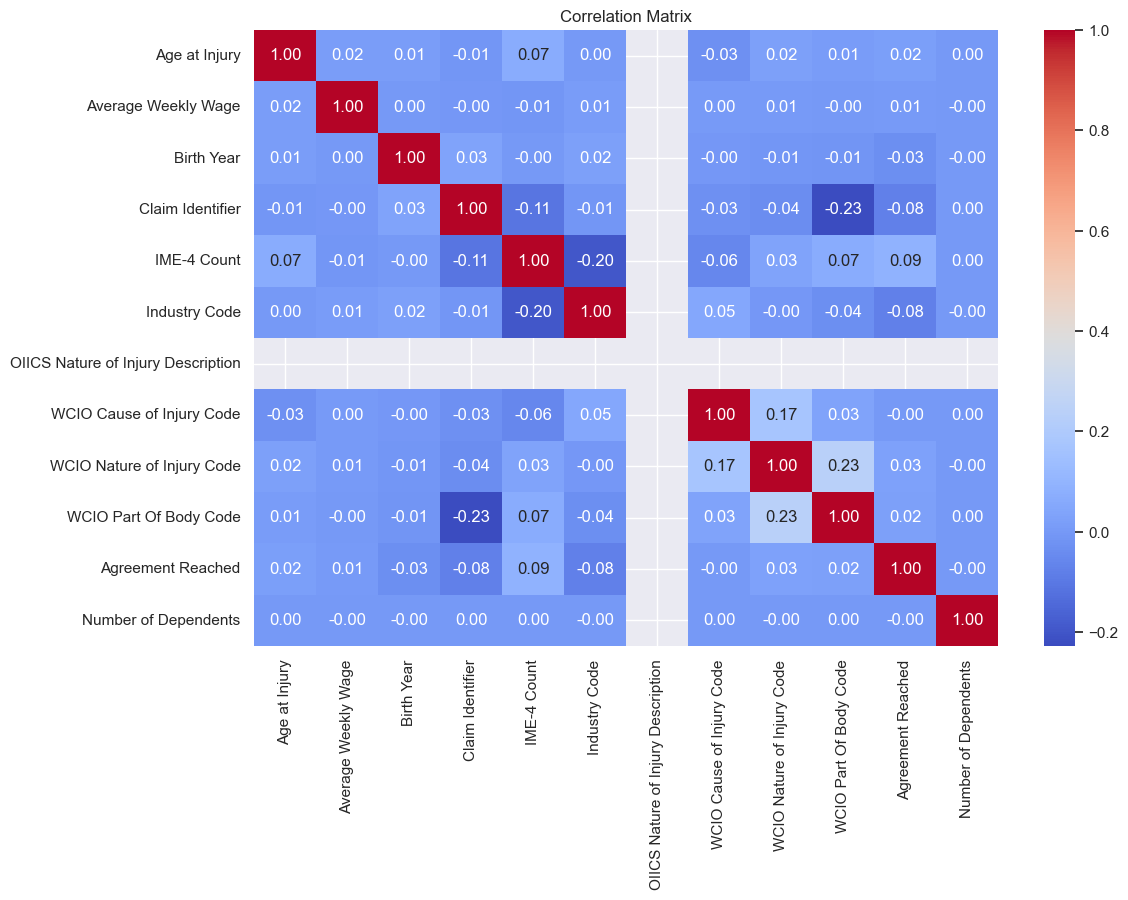

In [636]:
corr_matrix = train[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Pre-Processing

set Claim Identifier as index

In [637]:
train.set_index('Claim Identifier', inplace=True) 
test.set_index('Claim Identifier', inplace=True)

#### Categorization

we had a code wrongly labeled, so we change it to have the value 0

In [638]:
train['WCIO Part Of Body Code'] = train['WCIO Part Of Body Code'].apply(lambda x: 0 if x < 0 else x)
test['WCIO Part Of Body Code'] = test['WCIO Part Of Body Code'].apply(lambda x: 0 if x < 0 else x)

instead of having Date columns, for each one we split into Year, Month and Day

In [639]:
## IN DATE
date_cols = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date'] 
for col in date_cols:
    # Convert to datetime
    train[col] = pd.to_datetime(train[col], errors='coerce')
    test[col] = pd.to_datetime(test[col], errors='coerce')
    
    # Extract year, month, and day
    train[f'{col}_Year'] = train[col].dt.year
    train[f'{col}_Month'] = train[col].dt.month
    train[f'{col}_Day'] = train[col].dt.day
    
    test[f'{col}_Year'] = test[col].dt.year
    test[f'{col}_Month'] = test[col].dt.month
    test[f'{col}_Day'] = test[col].dt.day
# Drop the original columns
train.drop(columns=date_cols, inplace=True)
test.drop(columns=date_cols, inplace=True)

In [640]:
date_cols = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']
int_cols = ['Age at Injury', 'Birth Year', 'IME-4 Count', 'Number of Dependents']
float_to_object = ['Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']

create dictionaries for mapping codes to descriptions

In [641]:
code_maps = {
    'Industry Code': train.dropna(subset=['Industry Code', 'Industry Code Description']).set_index('Industry Code')['Industry Code Description'].to_dict(),
    'WCIO Cause of Injury Code': train.dropna(subset=['WCIO Cause of Injury Code', 'WCIO Cause of Injury Description']).set_index('WCIO Cause of Injury Code')['WCIO Cause of Injury Description'].to_dict(),
    'WCIO Nature of Injury Code': train.dropna(subset=['WCIO Nature of Injury Code', 'WCIO Nature of Injury Description']).set_index('WCIO Nature of Injury Code')['WCIO Nature of Injury Description'].to_dict(),
    'WCIO Part Of Body Code': train.dropna(subset=['WCIO Part Of Body Code', 'WCIO Part Of Body Description']).set_index('WCIO Part Of Body Code')['WCIO Part Of Body Description'].to_dict()
}

#### Drop Columns

WCB Decision is not in test and have just one value

In [642]:
train.drop(['WCB Decision'], inplace = True, axis = 1)

the column don't have data

In [643]:
train.drop(['OIICS Nature of Injury Description'], inplace=True, axis=1)
test.drop(['OIICS Nature of Injury Description'], inplace=True, axis=1)

#### Drop Rows

we eliminate the lines that do not have Claim Injury Type

In [644]:
train.dropna(subset=['Claim Injury Type'], inplace=True)

we eliminate rows with only 1, 2 or 3 NaN values, as we see that 'C-3 Date', 'First Hearing Date' and 'IME-4 Count' columns have +- 70% of the values ​​missing

In [645]:
train = train.dropna(thresh=4)

<hr>
<a class="anchor" id="missingvalues">
    
## Missing Values
    
</a>

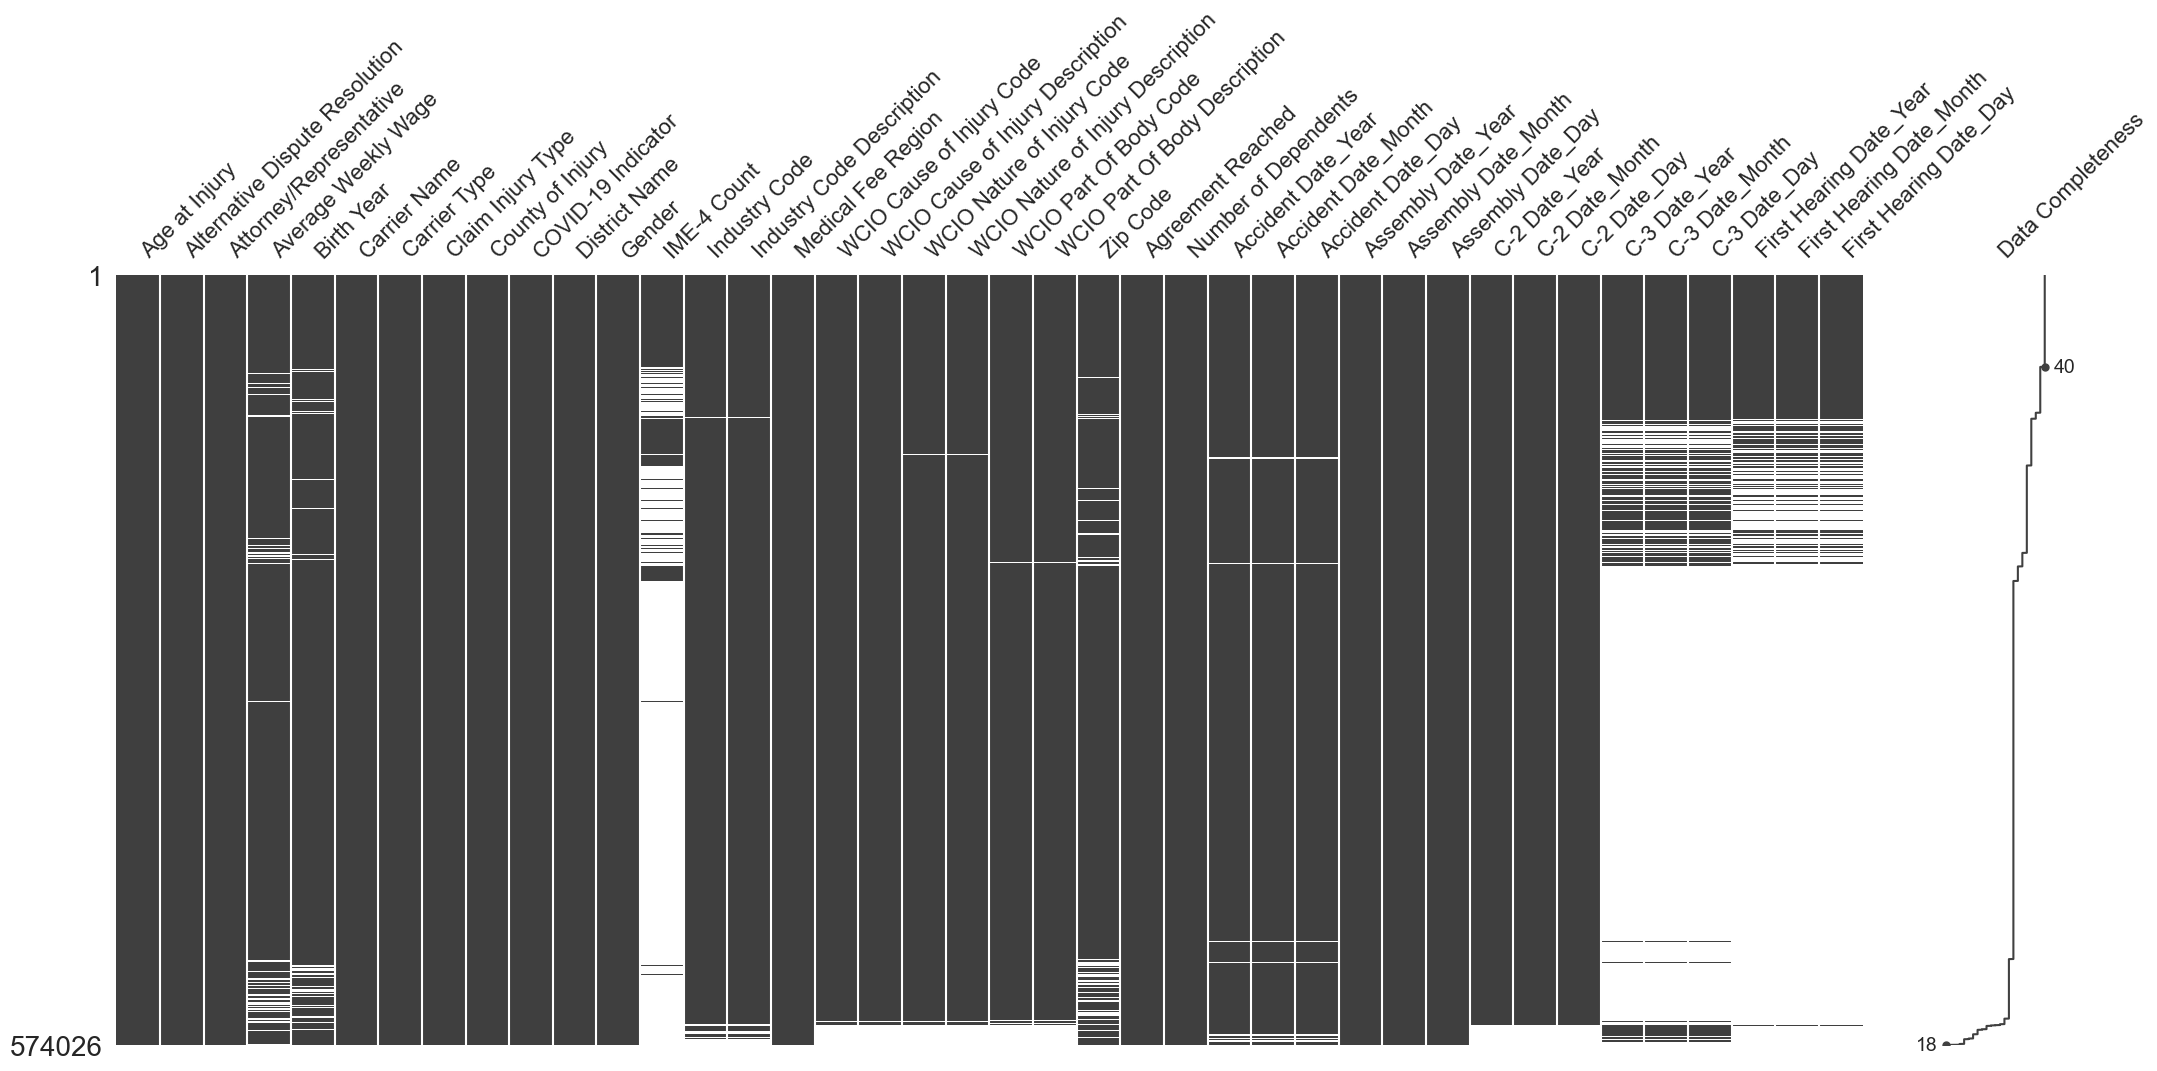

In [646]:
msno.matrix(train, labels=True, sort="descending");

In [647]:
train.isna().sum()

Age at Injury                             0
Alternative Dispute Resolution            0
Attorney/Representative                   0
Average Weekly Wage                   28651
Birth Year                            29078
Carrier Name                              0
Carrier Type                              0
Claim Injury Type                         0
County of Injury                          0
COVID-19 Indicator                        0
District Name                             0
Gender                                    0
IME-4 Count                          441223
Industry Code                          9958
Industry Code Description              9958
Medical Fee Region                        0
WCIO Cause of Injury Code             15640
WCIO Cause of Injury Description      15640
WCIO Nature of Injury Code            15657
WCIO Nature of Injury Description     15657
WCIO Part Of Body Code                17082
WCIO Part Of Body Description         17082
Zip Code                        

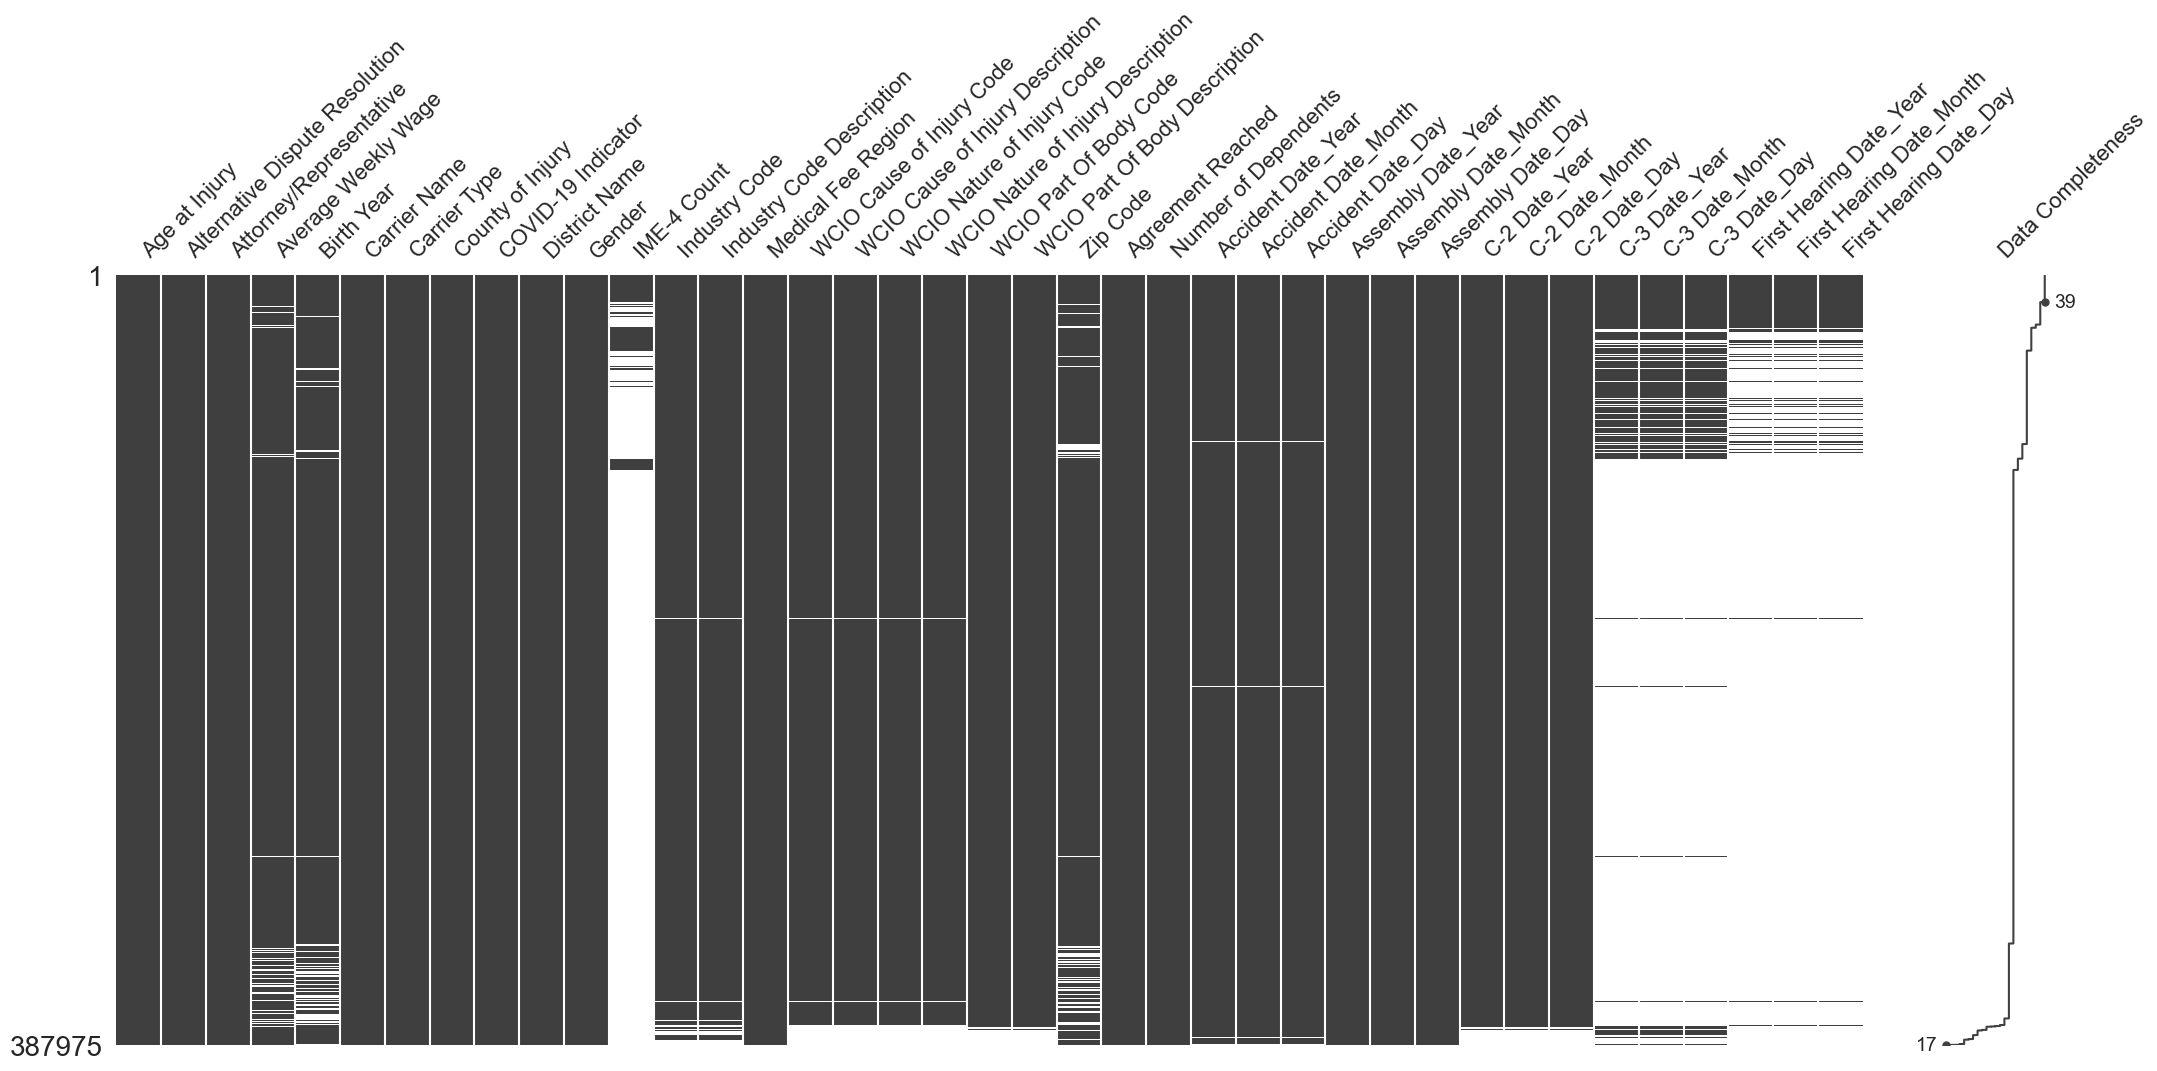

In [648]:
msno.matrix(test, labels=True, sort="descending");

In [649]:
test.isna().sum()

Age at Injury                             0
Alternative Dispute Resolution            0
Attorney/Representative                   0
Average Weekly Wage                   19204
Birth Year                            19470
Carrier Name                              0
Carrier Type                              0
County of Injury                          0
COVID-19 Indicator                        0
District Name                             0
Gender                                    0
IME-4 Count                          352726
Industry Code                          7736
Industry Code Description              7736
Medical Fee Region                        0
WCIO Cause of Injury Code             10348
WCIO Cause of Injury Description      10348
WCIO Nature of Injury Code            10560
WCIO Nature of Injury Description     10560
WCIO Part Of Body Code                 9549
WCIO Part Of Body Description          9549
Zip Code                              19342
Agreement Reached               

### Data Partition

we split our training data into train and validation

we can do this using some techniques like train_test_split or using kfold or stratifiedkfold

In [650]:
def split_data(X, y, method=None):
    splits = []
    if method is None:
        X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3, 
                                                random_state = 0, 
                                                stratify = y, 
                                                shuffle = True)
        splits.append((X_train, X_val, y_train, y_val))
    elif isinstance(method, StratifiedKFold):
        for train_index, test_index in method.split(X, y):
            X_train, X_val = X.iloc[train_index], X.iloc[test_index]
            y_train, y_val = y.iloc[train_index], y.iloc[test_index]
            splits.append((X_train, X_val, y_train, y_val))
    else:
        for train_index, test_index in method.split(X):
            X_train, X_val = X.iloc[train_index], X.iloc[test_index]
            y_train, y_val = y.iloc[train_index], y.iloc[test_index]
            splits.append((X_train, X_val, y_train, y_val))

    processed_splits = []
    for X_train, X_val, y_train, y_val in splits:
        X_train_num = X_train.select_dtypes(include=np.number)
        X_val_num = X_val.select_dtypes(include=np.number)
        X_train_cat = X_train.select_dtypes(exclude=np.number)
        X_val_cat = X_val.select_dtypes(exclude=np.number)
        processed_splits.append((X_train_num, X_val_num, X_train_cat, X_val_cat, y_train, y_val))

    return processed_splits

### Pre-Processing Functions

In [651]:
def convert_to_datetime(df, date_cols):
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    return df

In [652]:
def add_datetime_cols(df, date_cols):
    df = df + date_cols
    return df

In [653]:
def convert_to_int(df, int_cols):
    for col in int_cols:
        df[col] = df[col].astype('Int64')
    return df

In [654]:
def convert_to_object(df, int_cols):
    for col in int_cols:
        df[col] = df[col].astype('object')
    return df

split our data into numeric and categorical features

In [655]:
def cat_num(df):
    df_num = df.select_dtypes(include=[np.number, 'datetime64[ns]'])
    df_cat = df.select_dtypes(include=['object'])
    return df_num, df_cat

combine the two dataframes

In [656]:
def combine(df_num, df_cat):
    df = pd.concat([df_num, df_cat], axis=1)
    return df

we used knn to fill the code columns, like 'Injury Code', with the value of the most similar claim 

and then accurately, using the dictionary build before, fill the associated description

In [657]:
def KNN_Imputer(X_train_num, X_val_num, X_test_num, X_train_cat, X_val_cat, X_test_cat, code_maps, float_to_object):
    print("KNN Imputer: Starting")

    # Select only the float_to_object features for KNN imputation
    float_to_object_features = [col for col in float_to_object if col in X_train_num.columns]
    print(f"Float to Object Features: {float_to_object_features}")

    X_train_num_knn = X_train_num[float_to_object_features]
    X_val_num_knn = X_val_num[float_to_object_features]
    X_test_num_knn = X_test_num[float_to_object_features]

    print(f"X_train_num_knn shape: {X_train_num_knn.shape}")
    print(f"X_val_num_knn shape: {X_val_num_knn.shape}")
    print(f"X_test_num_knn shape: {X_test_num_knn.shape}")

    # Impute missing values in float_to_object features using KNN
    imputer = KNNImputer(n_neighbors=1).fit(X_train_num_knn)
    train_num_imp_knn = imputer.transform(X_train_num_knn)
    val_num_imp_knn = imputer.transform(X_val_num_knn)
    test_num_imp_knn = imputer.transform(X_test_num_knn)

    print(f"Train Num Imp KNN shape: {train_num_imp_knn.shape}")
    print(f"Val Num Imp KNN shape: {val_num_imp_knn.shape}")
    print(f"Test Num Imp KNN shape: {test_num_imp_knn.shape}")

    # Convert imputed numerical features back to DataFrames
    train_num_df_knn = pd.DataFrame(train_num_imp_knn, columns=X_train_num_knn.columns, index=X_train_num_knn.index)
    val_num_df_knn = pd.DataFrame(val_num_imp_knn, columns=X_val_num_knn.columns, index=X_val_num_knn.index)
    test_num_df_knn = pd.DataFrame(test_num_imp_knn, columns=X_test_num_knn.columns, index=X_test_num_knn.index)

    print(f"Train Num DF KNN shape: {train_num_df_knn.shape}")
    print(f"Val Num DF KNN shape: {val_num_df_knn.shape}")
    print(f"Test Num DF KNN shape: {test_num_df_knn.shape}")

    # Replace the original float_to_object features with the imputed ones
    X_train_num[float_to_object_features] = train_num_df_knn
    X_val_num[float_to_object_features] = val_num_df_knn
    X_test_num[float_to_object_features] = test_num_df_knn

    # Combine numerical and categorical features
    train_combined = combine(X_train_num, X_train_cat)
    val_combined = combine(X_val_num, X_val_cat)
    test_combined = combine(X_test_num, X_test_cat)

    print(train_combined.columns)
    
    # Map codes to descriptions
    for code, map_dict in code_maps.items():
        code_name = code.replace(' Code', '')
        if f'{code_name} Description' in train_combined.columns:
            print(f"Mapping code {code} to description")
            train_combined[f'{code_name} Description'] = train_combined[code].map(map_dict).fillna(train_combined[f'{code_name} Description'])
            val_combined[f'{code_name} Description'] = val_combined[code].map(map_dict).fillna(val_combined[f'{code_name} Description'])
            test_combined[f'{code_name} Description'] = test_combined[code].map(map_dict).fillna(test_combined[f'{code_name} Description'])
        else:
            print(f"Column {code_name} Description does not exist")

    X_train_num = train_combined.select_dtypes(include=np.number)
    X_val_num = val_combined.select_dtypes(include=np.number)
    X_test_num = test_combined.select_dtypes(include=np.number)
    X_train_cat = train_combined.select_dtypes(exclude=np.number)
    X_val_cat = val_combined.select_dtypes(exclude=np.number)
    X_test_cat = test_combined.select_dtypes(exclude=np.number)

    return X_train_num, X_val_num, X_test_num, X_train_cat, X_val_cat, X_test_cat

we decided to input the other's missing values with the median or most frequent value

In [658]:
def imputing(X_train_num, X_val_num, X_test_num, X_train_cat, X_val_cat, X_test_cat):
   
    print("Num median imputing: Starting")
    #Using median for numerical data
    num_imputer = SimpleImputer(strategy="median")
    X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train_num), columns=X_train_num.columns)
    X_val_num = pd.DataFrame(num_imputer.transform(X_val_num), columns=X_val_num.columns)
    X_test_num = pd.DataFrame(num_imputer.transform(X_test_num), columns=X_test_num.columns)

    print("Cat most frequent imputing: Starting")
    #Using most frequent for categorical data
    cat_imputer = SimpleImputer(strategy="most_frequent")
    X_train_cat = pd.DataFrame(cat_imputer.fit_transform(X_train_cat), columns=X_train_cat.columns)
    X_val_cat = pd.DataFrame(cat_imputer.transform(X_val_cat), columns=X_val_cat.columns)
    X_test_cat = pd.DataFrame(cat_imputer.transform(X_test_cat), columns=X_test_cat.columns)

    return X_train_num, X_val_num, X_test_num, X_train_cat, X_val_cat, X_test_cat

### Preprocessing

this function change the columns to their correct type and use split_data to split our train dataset

In [659]:
def preprocess_data(train, test):
    
    # train = convert_to_datetime(train, date_cols)
    # test = convert_to_datetime(test, date_cols)

    train = convert_to_int(train, int_cols)
    test = convert_to_int(test, int_cols)

    train = convert_to_int(train, float_to_object)
    test = convert_to_int(test, float_to_object)
    
    X_test_num, X_test_cat = cat_num(test)

    X = train.drop('Claim Injury Type', axis=1)
    y = train['Claim Injury Type']
    
    splits = split_data(X, y)
    print("Split data OK.")

    return splits, X_test_num, X_test_cat

<hr>
<a class="anchor" id="datapreprocessing">
    
# 4. Feature Engineering
    
</a>



In [660]:
def feature_engineering(df, feature_set='basic'):
    df = df.copy()
    print(f"Initial shape: {df.shape}")
    
    # Date feature engineering
    for col in date_cols:
        
        # Extract year, month, and day
        df[f'{col}_Year'] = df[col].dt.year
        df[f'{col}_Month'] = df[col].dt.month
        df[f'{col}_Day'] = df[col].dt.day
    
    # Date feature engineering
    df['Assembly_to_Accident'] = (df['Assembly Date'] - df['Accident Date']).dt.days
    df['C2_to_Accident'] = (df['C-2 Date'] - df['Accident Date']).dt.days
    df['C3_to_Accident'] = (df['C-3 Date'] - df['Accident Date']).dt.days
    df['Hearing_to_Accident'] = (df['First Hearing Date'] - df['Accident Date']).dt.days

    # Age-based features
    df['Age_at_Assembly'] = df['Age at Injury'] + (df['Assembly Date'] - df['Accident Date']).dt.days / 365
    df['Age_at_C2'] = df['Age at Injury'] + (df['C-2 Date'] - df['Accident Date']).dt.days / 365
    df['Age_at_C3'] = df['Age at Injury'] + (df['C-3 Date'] - df['Accident Date']).dt.days / 365
    df['Age_at_Hearing'] = df['Age at Injury'] + (df['First Hearing Date'] - df['Accident Date']).dt.days / 365
    
    # Additional feature engineering
    if 'Average Weekly Wage' in df.columns:
        # Fill missing values with the median wage
        df['Average Weekly Wage'] = df['Average Weekly Wage'].fillna(df['Average Weekly Wage'].median())
    
        # Create a temporary column for wages greater than 0
        positive_wages = df['Average Weekly Wage'] > 0
    
        # Apply qcut to positive wages only
        wage_groups = pd.qcut(
            df.loc[positive_wages, 'Average Weekly Wage'], 
            q=10, 
            labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        )
    
    # Assign the results back to the dataframe
    df['Wage_Group'] = 0  # Default to 0 (avg weekly wage = 0)
    df.loc[positive_wages, 'Wage_Group'] = wage_groups.astype(int)  # Overwrite for positive wages
    
    # assume 'df' is your DataFrame with the county names
    df['Distance to NYC'] = df['District Name'].map({
        'NYC': 0,
        'ALBANY': 155,
        'HAUPPAUGE': 45,
        'BUFFALO': 373,
        'SYRACUSE': 198,
        'ROCHESTER': 338,
        'BINGHAMTON': 173
    })

    mean_distance = df[df['District Name'] != 'STATEWIDE']['Distance to NYC'].mean()
    df.loc[df['District Name'] == 'STATEWIDE', 'Distance to NYC'] = mean_distance

    # Assuming df_train is your DataFrame
    counties = { "SUFFOLK": 45.4, "QUEENS": 8.5, "KINGS": 7.5, "NASSAU": 20.1,
            "BRONX": 10.3, "ERIE": 371.1, "NEW YORK": 0, "WESTCHESTER": 20.5,
            "MONROE": 334.8, "ORANGE": 59.5, "ONONDAGA": 194.8, "RICHMOND": 17.1,
            "ALBANY": 155.1, "DUTCHESS": 76.3, "ROCKLAND": 30.8, "SARATOGA": 143.1, 
            "NIAGARA": 373.9, "BROOME": 173.1, "ONEIDA": 203.1, "RENSSELAER": 145.9, 
            "ULSTER": 86.3, "CAYUGA": 221.9, "HERKIMER": 213.9, "CHAUTAUQUA": 407.9, 
            "ONTARIO": 264.9, "CHEMUNG": 201.9, "OSWEGO": 243.9, "FULTON": 223.1, 
            "PUTNAM": 51.9, "ST. LAWRENCE": 314.9, "JEFFERSON": 341.1, "CLINTON": 304.9, 
            "CATTARAUGUS": 371.9, "SULLIVAN": 97.3, "GENESEE": 344.9, "COLUMBIA": 120.1,
            "MADISON": 193.9, "WARREN": 194.9, "LIVINGSTON": 276.9, "DELAWARE": 137.1,
            "WASHINGTON": 204.9, "GREENE": 124.9, "ALLEGANY": 346.9, "WAYNE": 294.9,
            "CHENANGO": 181.9, "TOMPKINS": 209.9, "ORLEANS": 323.9, "SCHENECTADY": 156.1,
            "FRANKLIN": 294.9, "SENECA": 234.9, "LEWIS": 266.9, "TIOGA": 187.1, "STEUBEN": 246.9, 
            "ESSEX": 214.9, "SCHUYLER": 206.1, "OTSEGO": 165.1, "CORTLAND": 193.9, 
            "WYOMING": 313.9, "MONTGOMERY": 173.9, "SCHOHARIE": 146.1, "YATES": 243.9,"HAMILTON": 221.9
    }

    # Create a list of distances
    distances = list(counties.values())

    # Calculate the mean distance
    mean_distance = statistics.mean(distances)

    # Add the "UNKNOWN" county to the dictionary with the mean distance
    counties["UNKNOWN"] = mean_distance

    # Create a new column in the df_train DataFrame called distance_of_county
    df['distance_of_county'] = df['County of Injury'].map(counties).fillna(mean_distance)

    print(f"Shape after feature engineering: {df.shape}")
    return df

<hr>
<a class="anchor" id="outliers">
    
## 4.4 Outliers
    
</a>

the rules that define what is an outlier

In [661]:
rules = {
    'Age at Injury': {'min': 14, 'max': 90},
    'Birth Year': {'iqr': 1.5},
    'Average Weekly Wage': {'iqr': 1.5, 'non_zero': True},
    'Accident Date_Year': {'date': 1980},
}

#'Accident Date': {'date': '1980-01-01'}

removing outliers

In [662]:
def clean_data(df, y, columns, rules, train=False):
    cleaned_df = df.copy()
    cleaned_df['Claim Injury Type'] = y

    for column in columns:
        if column in rules:
            rule = rules[column]
            if 'min' in rule and 'max' in rule:
                cleaned_df = cleaned_df[(cleaned_df[column] >= rule['min']) & (cleaned_df[column] <= rule['max'])]
            elif 'iqr' in rule:
                if train:
                    Q1 = df[column].quantile(0.25)
                    Q3 = df[column].quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - rule['iqr'] * IQR
                    upper_bound = Q3 + rule['iqr'] * IQR
                    rule['min'] = lower_bound
                    rule['max'] = upper_bound
                cleaned_df = cleaned_df[(cleaned_df[column] >= rule['min']) & (cleaned_df[column] <= rule['max'])]
            elif 'non_zero' in rule:
                cleaned_df = cleaned_df[cleaned_df[column] != 0]
            elif 'date' in rule:
                cleaned_df = cleaned_df[cleaned_df[column] <= rule['date']]
    cleaned_y = cleaned_df['Claim Injury Type']
    cleaned_df = cleaned_df.drop('Claim Injury Type', axis=1)

    return cleaned_df, cleaned_y

### Encoding

we use encoding to prepare our categorical features to be used by a model

In [663]:
def encode(X_train, X_val, X_test, y_train, y_val, encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)):
    X_train = X_train.astype(str)
    X_val = X_val.astype(str)
    X_test = X_test.astype(str)
    
    encoder.fit(X_train)
    X_train_encoded = encoder.transform(X_train) 
    X_val_encoded = encoder.transform(X_val)
    X_test_encoded = encoder.transform(X_test)

    if isinstance(encoder, OneHotEncoder):
        feature_names = encoder.get_feature_names_out(X_train.columns)
        X_train_encoded = pd.DataFrame(X_train_encoded, columns=feature_names, index=X_train.index)
        X_val_encoded = pd.DataFrame(X_val_encoded, columns=feature_names, index=X_val.index)
        X_test_encoded = pd.DataFrame(X_test_encoded, columns=feature_names, index=X_test.index)
    else:
        X_train_encoded = pd.DataFrame(X_train_encoded, columns=X_train.columns, index=X_train.index)
        X_val_encoded = pd.DataFrame(X_val_encoded, columns=X_val.columns, index=X_val.index)
        X_test_encoded = pd.DataFrame(X_test_encoded, columns=X_test.columns, index=X_test.index)

    encoder_y = LabelEncoder().fit(y_train)
    y_train_encoded = pd.Series(encoder_y.transform(y_train))
    y_test_encoded = pd.Series(encoder_y.transform(y_val))
    
    return X_train_encoded, X_val_encoded, X_test_encoded, y_train_encoded, y_test_encoded

<hr>
<a class="anchor" id="scaling">
    
## 4.7 Scaling
    
</a>

we scaled our data to improve model performance and to equal the features contributions

In [664]:
def scaler_method(method='minmax'):
    
    if method == 'minmax':
        return MinMaxScaler()
    elif method == 'standard':
        return StandardScaler()
    elif method == 'robust':
        return RobustScaler()
    else:
        raise ValueError("Invalid scaling method. Options are 'minmax' and 'standard'.")

In [665]:
def scale_data(X_train, X_val, X_test, method='minmax'):
    
    scaler = scaler_method(method)
    
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X_val.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train_scaled, X_val_scaled, X_test_scaled

<hr>
<a class="anchor" id="featureselection">
    
# 5. Feature selection
    
</a>

<hr>
<a class="anchor" id="correlations">
    
## 5.1 Correlations
    
</a>

In [666]:
def cor_heatmap(data):
    
    corr = data.corr(method='pearson')
    
    corr_masked = corr.copy()
    corr_masked[(corr_masked > -0.5) & (corr_masked < 0.5)] = np.nan

    mask = np.triu(np.ones_like(corr_masked, dtype=bool))

    f, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(corr, mask=mask, cmap='RdBu', vmax=1, vmin=-1, center=0,
                square=True, annot=True, annot_kws={'size': 10}, linewidths=0.5, cbar_kws={"shrink": 0.5},
                fmt='.1f')

    for text in ax.texts:
        if abs(float(text.get_text())) < 0.3:
            text.set_text('') 

    plt.show()

#cor_heatmap(X_train_num)

In [667]:
def selection_corr(X_train, X_val, X_test, threshold=0.8):
    corr = X_train.corr(method='pearson')
    corr_masked = corr.copy()
    corr_masked[(corr_masked > -threshold) & (corr_masked < threshold)] = np.nan

    to_drop = []
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > threshold:
                if corr.columns[j] not in to_drop:
                    to_drop.append(corr.columns[j])
                break

    X_train_dropped = X_train.drop(to_drop, axis=1)
    X_val_dropped = X_val.drop(to_drop, axis=1)
    X_test_dropped = X_test.drop(to_drop, axis=1)
    
    return X_train_dropped, X_val_dropped, X_test_dropped

<hr>
<a class="anchor" id="chisquare">
    
## 5.2 Chi-Square
    
</a>

In [668]:
#is not giving relevant information for now
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result=p, "{0} is IMPORTANT for Prediction".format(var)
    else:
        result=p, "{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

# for var in X_train_cat_df:
#     TestIndependence(X_train_cat_df[var],y_train, var)

<hr>
<a class="anchor" id="lassocv">
    
## 5.3 LassoCV
    
</a>

In [669]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [670]:
def selection_lasso(X_train, X_val, X_test, y_train):
    
    reg = LassoCV()
    reg.fit(X_train, y_train)
    coef = pd.Series(reg.coef_, index=X_train.columns)
    
    columns_to_keep = coef[coef != 0].index
    
    X_train_columns_to_keep = X_train[columns_to_keep]
    X_val_columns_to_keep = X_val[columns_to_keep]
    X_test_columns_to_keep = X_test[columns_to_keep]
    
    return X_train_columns_to_keep, X_val_columns_to_keep, X_test_columns_to_keep

#### Decision Trees

In [671]:
def selection_dt(X_train, X_val, X_test, y_train, n_to_drop=2):
    
    # Calculate feature importances using Gini and Entropy
    gini_importance = DecisionTreeClassifier().fit(X_train, y_train).feature_importances_
    entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(X_train, y_train).feature_importances_

    # Create a dataframe with the feature importances
    zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns=['gini', 'entropy'])
    zippy['col'] = X_train.columns
    tidy = zippy.melt(id_vars='col').rename(columns=str.title)

    # Sort the features by importance and select the least valuable ones
    least_valuable = tidy.sort_values('Value', ascending=True).head(n_to_drop)

    # Drop the least valuable features from the training, validation, and testing data
    X_train_dropped = X_train.drop(least_valuable['col'].values, axis=1)
    X_val_dropped = X_val.drop(least_valuable['col'].values, axis=1)
    X_test_dropped = X_test.drop(least_valuable['col'].values, axis=1)

    return X_train_dropped, X_val_dropped, X_test_dropped

In [672]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# # Assume X_train and y_train are your training data and labels
# # Get the unique class labels in y_train
# class_labels = np.unique(y_train)

# # Melt the data into a long format
# melted_data = pd.melt(X_train_columns_to_keep, value_vars=X_train_columns_to_keep.columns, var_name="feature", value_name="value")

# # Repeat y_train for each value in the melted data
# repeated_y_train = np.repeat(y_train, len(X_train_columns_to_keep.columns))

# # Add the repeated class labels to the melted data
# melted_data["class"] = repeated_y_train

# # Plot a facet grid with KDEs for each feature and class label
# sns.set(style="whitegrid")
# g = sns.FacetGrid(melted_data, col="feature", hue="class", col_wrap=4)
# g.map(sns.kdeplot, "value")
# g.set(xlim=(-3, 3.5))  # Set the x-axis range to -3-3
# g.set(ylim=(0, 3))  # Set the y-axis range to 0-0.5
# g.add_legend()
# plt.show()

<hr>
<a class="anchor" id="balancingdata">
    
## 5.4 Balancing Data
    
</a>

In [673]:
def custom_sampling_strategy(y):
    class_counts = np.bincount(y)
    max_count = np.max(class_counts)
    sampling_strategy = {}
    for i, count in enumerate(class_counts):
        if i in [5, 6, 7]:  # minority classes
            sampling_strategy[i] = 4000
        else:
            sampling_strategy[i] = count  # use the original count for other classes
    return sampling_strategy

## Pipeline

In [674]:
def pipeline(train, test):
    #pre-processing
    splits, X_test_num, X_test_cat  = preprocess_data(train, test)

    # Initialize results storage for each split
    results = {}

    for i, (X_train_num, X_val_num, X_train_cat, X_val_cat, y_train, y_val) in enumerate(splits):
        # X_train_num, X_val_num, X_test_num, X_train_cat, X_val_cat, X_test_cat = KNN_Imputer(X_train_num, X_val_num,
        #                                                                                  X_test_num, X_train_cat,
        #                                                                                  X_val_cat, X_test_cat, 
        #                                                                                  code_maps, float_to_object)
    
        X_train_num, X_val_num, X_test_num, X_train_cat, X_val_cat, X_test_cat = imputing(X_train_num, X_val_num,
                                                                                      X_test_num, X_train_cat,
                                                                                      X_val_cat, X_test_cat)

        X_train = combine(X_train_num, X_train_cat)
        X_val = combine(X_val_num, X_val_cat)
        X_test = combine(X_test_num, X_test_cat)

        X_train = convert_to_object(X_train, float_to_object)
        X_val = convert_to_object(X_val, float_to_object)
        X_test = convert_to_object(X_test, float_to_object)

        # #feature engineering
        # X_train = feature_engineering(X_train, feature_set='basic')
        # X_val = feature_engineering(X_val, feature_set='basic')
        # X_test = feature_engineering(test, feature_set='basic')

        # #creates rules for training data
        # X_train, y_train = clean_data(X_train, y_train, ['Age at Injury', 'Birth Year', 'Average Weekly Wage', 'Accident Date'], rules, train=True)
        
        # #utilizes the rules created for training data on validation data
        # X_val, y_val = clean_data(X_val, y_val, ['Age at Injury', 'Birth Year', 'Average Weekly Wage', 'Accident Date'], rules)

        #encoding
        X_train_num = X_train.select_dtypes(include=np.number)
        X_val_num = X_val.select_dtypes(include=np.number)
        X_test_num = X_test.select_dtypes(include=np.number)
        X_train_cat = X_train.select_dtypes(exclude=np.number)
        X_val_cat = X_val.select_dtypes(exclude=np.number)
        X_test_cat = X_test.select_dtypes(exclude=np.number)
        X_train_cat, X_val_cat, X_test_cat, y_train, y_val = encode(X_train_cat, X_val_cat, X_test_cat, y_train, y_val)

        #scaling
        X_train = combine(X_train_num, X_train_cat)
        X_val = combine(X_val_num, X_val_cat)
        X_test = combine(X_test_num, X_test_cat)
        X_train, X_val, X_test = scale_data(X_train, X_val, X_test, 'standard')

        # #feature selection
        # #correlation
        # X_train, X_val, X_test = selection_corr(X_train, X_val, X_test, threshold = 0.8)

        # #lasso
        # X_train, X_val, X_test = selection_lasso(X_train, X_val, X_test, y_train)

        # #decision trees
        # X_train, X_val, X_test = selection_dt(X_train, X_val, X_test, y_train, n_to_drop = 2)

        #balancing
        print(X_train.shape, y_train.shape)
        smote = SMOTE(random_state=42, sampling_strategy=custom_sampling_strategy)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        results[i] = (X_train, X_val, X_test, y_train, y_val)

    return results

In [675]:
processed_data = pipeline(train, test)
processed_data

Split data OK.
Num median imputing: Starting
Cat most frequent imputing: Starting
(401818, 39) (401818,)


{0: (        Age at Injury  Average Weekly Wage  Birth Year  IME-4 Count  \
  0           -0.078860             0.114261    0.216584    -0.192581   
  1           -1.341006            -0.033100    0.263588    -0.192581   
  2           -1.200768            -0.085572    0.258640    -0.192581   
  3            1.183286            -0.085572    0.174527    -0.192581   
  4            0.902809            -0.085572    0.186897    -0.192581   
  ...               ...                  ...         ...          ...   
  410468      -0.080270            -0.031104    0.221581    -0.192581   
  410469       1.238217            -0.085572    0.165831    -0.284761   
  410470       0.694701             0.150599    0.189005    -0.192581   
  410471       0.982060             0.069909    0.182012    -0.192581   
  410472       1.167240            -0.085572    0.170146    -0.192581   
  
          Agreement Reached  Number of Dependents  Accident Date_Year  \
  0               -0.221833             -0.00

## Models

#### Gradient Boost

In [ ]:
def train_xgb(X_train, y_train, random_state=42):
    """Train XGB model"""
    print("\nTraining XGB model...")
    print(f"Starting training with {X_train.shape[1]} features...")
    
    model = XGBClassifier(
        n_estimators=250,
        learning_rate=0.1,
        max_depth=6,
        random_state=random_state,
        n_jobs=2,
        tree_method='hist',
        enable_categorical=True,
        objective='multi:softprob',
        num_class=8,
        eval_metric=['mlogloss', 'merror'],
        use_label_encoder=False
    )
    
    # Train with early stopping
    eval_set = [(X_train, y_train)]
    model.fit(
        X_train, y_train,
        eval_set=eval_set,
        verbose=True
    )
    
    return model

#### Histogram Gradient Boost

In [ ]:
def train_hist_gb(X_train, y_train, random_state=42):
    """Train HistGB model"""
    print("\nTraining HistGB model...")
    print(f"Starting training with {X_train.shape[1]} features...")
    
    model = HistGradientBoostingClassifier(
        max_iter=100,
        learning_rate=0.1,
        max_depth=None,
        random_state=random_state,
        verbose=1
    )
    model.fit(X_train, y_train)
    
    return model

#### Random Forest

In [ ]:
def train_simple_rf(X_train, y_train, random_state=42):
    """Train Simple RF model"""
    print("\nTraining Simple RF model...")
    print(f"Starting training with {X_train.shape[1]} features...")
    
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=random_state,
        n_jobs=2,
        verbose=1,
        class_weight='balanced'
    )
    model.fit(X_train, y_train)
    
    return model

#### Gaussian NB

In [ ]:
def train_gaussian_nb(X_train, y_train):
    """Train GaussianNB model"""
    print("\nTraining GaussianNB model...")
    print(f"Starting training with {X_train.shape[1]} features...")
    
    model = GaussianNB()
    model.fit(X_train, y_train)
    
    return model

#### Logistic Regression

In [ ]:
def train_logistic_regression(X_train, y_train):
    """Train Logistic Regression model"""
    print("\nTraining Logistic Regression model...")
    print(f"Starting training with {X_train.shape[1]} features...")
    
    model = LogisticRegression(class_weight='balanced', max_iter=1000)
    model.fit(X_train, y_train)
    
    return model

<hr>
<a class="anchor" id="evaluate">
    
# 6.2 Evaluate the model
    
</a> 

In [ ]:
def classification_report(X_train, y_train, X_val, y_val, X_test):
    models = {
        'LogisticRegression': modelLR,
        'XGB': modelXGB,
        'HistGB': modelHGB,
        'RF': modelRF,
        'GaussianNB': modelCNB
    }

    best_model = None
    best_score = 0
    best_report = None

    for name, model in models.items():
        print(f"Model: {name}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        report = classification_report(y_val, y_pred)
        print(report)
        score = f1_score(y_val, y_pred, average='macro')
        print(f"F1-score: {score:.4f}")
        print()

        if score > best_score:
            best_score = score
            best_model = model
            best_report = report

    print(f"Best model: {best_model.__class__.__name__}")
    print("Best classification report:")
    print(best_report)
    print("Test prediction:")
    test_pred = best_model.predict(X_test)
    
    return test_pred, best_model

test_pred, best_model = classification_report(X_train, y_train, X_val, y_val, X_test)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities on the validation set
y_pred_proba = model.predict_proba(X_val_columns_to_keep)

encoder = LabelBinarizer()
y_true_onehot = encoder.fit_transform(y_val)

# Plot ROC curve for each class
for i in range(y_true_onehot.shape[1]):
    fpr, tpr, thresholds = roc_curve(y_true_onehot[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (area = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def evaluate_model(model, X_val, y_val, X_test=None):
    y_val_pred = model.predict(X_val)
    
    val_metrics = {
        'accuracy': accuracy_score(y_val, y_val_pred),
        'f1_macro': f1_score(y_val, y_val_pred, average='macro')
    }
    
    print("\nValidation Results:")
    print("\nClassification Report:")
    print(classification_report(y_val, y_val_pred))
    print("\nMetrics:")
    for metric, value in val_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    test_pred = None
    if X_test is not None:
        test_pred = model.predict(X_test)
    
    return val_metrics, test_pred
    
val_metrics, test_pred = evaluate_model(model, X_val_combined_scaled, y_val, X_test_combined_scaled)

In [ ]:
def evaluate_model(model, X_val, y_val, X_test=None):
    y_val_pred = model.predict(X_val)
    
    val_metrics = {
        'accuracy': accuracy_score(y_val, y_val_pred),
        'f1_macro': f1_score(y_val, y_val_pred, average='macro')
    }
    
    print("\nValidation Results:")
    print("\nClassification Report:")
    print(classification_report(y_val, y_val_pred))
    print("\nMetrics:")
    for metric, value in val_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    test_pred = None
    if X_test is not None:
        test_pred = model.predict(X_test)
    
    return val_metrics, test_pred
    
val_metrics, test_pred = evaluate_model(modelLR, X_val_combined_scaled, y_val, X_test_combined_scaled)

In [ ]:
def evaluate_model(model, X_val, y_val, X_test=None, threshold_2=0.5, threshold_5=0.5, threshold_6=0.5):
    y_val_pred_proba = model.predict_proba(X_val)
    y_val_pred = np.argmax(y_val_pred_proba, axis=1)
    
    # Adjust the threshold for classes 2, 5, and 6
    for i, proba in enumerate(y_val_pred_proba):
        if y_val[i] == 2 and proba[2] >= threshold_2:
            y_val_pred[i] = 2
        elif y_val[i] == 5 and proba[5] >= threshold_5:
            y_val_pred[i] = 5
        elif y_val[i] == 6 and proba[6] >= threshold_6:
            y_val_pred[i] = 6
    
    val_metrics = {
        'accuracy': accuracy_score(y_val, y_val_pred),
        'f1_macro': f1_score(y_val, y_val_pred, average='macro')
    }
    
    print("\nValidation Results:")
    print("\nClassification Report:")
    print(classification_report(y_val, y_val_pred))
    print("\nMetrics:")
    for metric, value in val_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    test_pred = None
    if X_test is not None:
        y_test_pred_proba = model.predict_proba(X_test)
        y_test_pred = np.argmax(y_test_pred_proba, axis=1)
        
        # Adjust the threshold for classes 2, 5, and 6
        for i, proba in enumerate(y_test_pred_proba):
            if proba[2] >= threshold_2:
                y_test_pred[i] = 2
            elif proba[5] >= threshold_5:
                y_test_pred[i] = 5
            elif proba[6] >= threshold_6:
                y_test_pred[i] = 6
        
        test_pred = y_test_pred
    
    return val_metrics, test_pred

val_metrics, test_pred = evaluate_model(model, X_val_columns_to_keep, y_val, X_test_columns_to_keep, threshold_2=0.1, threshold_5=0.1, threshold_6=0.05)

<hr>
<a class="anchor" id="export">
    
# 6.3 Export the predictor
    
</a> 

In [ ]:
CLAIM_TYPE_MAPPING = {
    1: '1. CANCELLED',
    2: '2. NON-COMP',
    3: '3. MED ONLY',
    4: '4. TEMPORARY',
    5: '5. PPD SCH LOSS',
    6: '6. PPD NSL',
    7: '7. PTD',
    8: '8. DEATH'
    }

def create_submission_df(predictions, test_df):
    # Add 1 to predictions to convert back to original scale (0-7 to 1-8)
    numeric_predictions = predictions + 1
    
    # Map numeric predictions to claim type strings
    claim_types = [CLAIM_TYPE_MAPPING[pred] for pred in numeric_predictions]
    
    # Create submission dataframe using original (unscaled) claim identifiers
    submission = pd.DataFrame({
        'Claim Identifier': test_df['Claim Identifier'].astype(int),  # Original claim IDs
        'Claim Injury Type': claim_types  # Full claim type names
    })
    
    return submission

In [ ]:
def save_submission(submission_df, experiment_name):
    filename = f'submission_{experiment_name}.csv'
    submission_df.to_csv(filename, index=False)
    print(f"\nSubmission saved to {filename}")
    
    # Display sample of submission
    print("\nSubmission sample:")
    print(submission_df.head())
    print("\nValue counts:")
    print(submission_df['Claim Injury Type'].value_counts())

In [ ]:
model_1 = 'Model new'
original_claim_ids = test.index.copy()
submission_df = create_submission_df(test_pred, pd.DataFrame({'Claim Identifier': original_claim_ids}))
save_submission(submission_df, model_1)

In [ ]:
aaa